# Training with PyTorch

**Note: `aenet-python` needs to be installed with the `[torch]` requirements (`pip install aenet[torch]`) for this notebook to work.**

This notebook demonstrates end-to-end training using the PyTorch trainer with on-the-fly featurization.

In [2]:
import os, sys

import math
from pathlib import Path
import numpy as np
import torch
import matplotlib.pyplot as plt

from aenet.torch_training import (
    TorchANNPotential,
    TorchTrainingConfig,
    Structure,
    save_model,
    export_history,
)
from aenet.torch_featurize import ChebyshevDescriptor
from aenet.formats.xsf import XSFParser

print(torch.__version__)

2.9.0


## Load a few TiO2 structures from repository data

The TiO2 XSF files used in tests may not always include forces, so we train energy-only here for speed and determinism.

In [3]:
def load_tio2_structures(n_structs: int = 3):
    xsf_dir = Path("./xsf-TiO2")
    files = sorted(xsf_dir.glob("*.xsf"))[:n_structs]
    parser = XSFParser()
    out = []
    for p in files:
        s = parser.read(str(p))
        positions = s.coords[-1]
        species = s.types
        try:
            energy = float(s.energy[-1])
        except:
            raise Error('The structure is not energy-labeled.')
        cell = np.array(s.avec[-1]) if s.pbc else None
        pbc = np.array([True, True, True]) if s.pbc else None
        out.append(Structure(positions=positions, 
                             species=species, 
                             energy=energy, 
                             forces=None, 
                             cell=cell, 
                             pbc=pbc, 
                             name=p.name))
    return out

structures = load_tio2_structures(n_structs=100)
len(structures), structures[0].n_atoms

(100, 23)

## Define descriptor and architecture

In [ ]:
descriptor = ChebyshevDescriptor(
    species=["Ti", "O"],
    rad_order=10,
    rad_cutoff=6.0,
    ang_order=3,
    ang_cutoff=3.5,
    min_cutoff=0.5,
    device="cpu",
    dtype=torch.float64,
)

arch = {
    "Ti": [(10, "tanh"), (10, "tanh")],
    "O": [(10, "tanh"), (10, "tanh")],
}

pot = TorchANNPotential(arch=arch, 
                        descriptor=descriptor)

## Configure and run training (energy-only)

In [ ]:
%%time

atomic_energies = {"Ti": -1604.604515075, "O": -432.503149303}

cfg = TorchTrainingConfig(
    iterations=100,
    testpercent=10,
    memory_mode="cpu",
    device="cpu",
    energy_target="cohesive",
    E_atomic=atomic_energies,
    force_weight=0.5,
    force_fraction=0.1,
    cached_features=True,
    cache_neighbors=True,
    cache_triplets=True
)

outputs = Path("example-05-outputs")
outputs.mkdir(parents=True, exist_ok=True)

history = pot.train(
    structures=structures,
    config=cfg,
    checkpoint_dir=str(outputs / "ckpts"),
    checkpoint_interval=1,
    max_checkpoints=5,
    save_best=True,
    use_scheduler=False,
)

## Plot training history

In [ ]:
epochs = range(1, len(history["train_energy_rmse"]) + 1)
plt.figure(figsize=(6,4))
plt.yscale('log')
plt.plot(epochs, history["train_energy_rmse"], label="train_energy_rmse")
if not math.isnan(history["test_energy_rmse"][0]):
    plt.plot(epochs, history["test_energy_rmse"], label="test_energy_rmse")
plt.xlabel("epoch"); plt.ylabel("RMSE (energy per-atom)"); plt.legend(); plt.tight_layout()
plot_path = outputs / "energy_rmse.png"
plt.savefig(plot_path, dpi=150)
plot_path

## Save model and history, then load and predict

In [ ]:
model_path = outputs / "trained_model.pt"
history_json = outputs / "history.json"
history_csv = outputs / "history.csv"

save_model(pot, model_path)
export_history(history, history_json, history_csv)

from aenet.torch_training import load_model
pot_loaded, meta = load_model(model_path)
energies, _ = pot_loaded.predict(structures[:1], predict_forces=False)
energies[0], meta["schema_version"], meta["descriptor_config"]["n_features"]

In [ ]:
structures[0]

In [5]:
from aenet.torch_training import load_model
import numpy as np

atomic_energies = {"Ti": -1604.604515075, "O": -432.503149303}

outputs = Path("example-05-outputs")
model_path = outputs / "trained_model.pt"
pot_loaded, meta = load_model(model_path)
test_structures = load_tio2_structures(n_structs=100)
test_structures = test_structures[10:]

E_ann, _ = pot_loaded.predict(test_structures, predict_forces=False)

energies = []
for i, s in enumerate(test_structures):
    E_ref = s.energy
    energies.append([E_ref, E_ann[i]])

energies = np.array(energies)

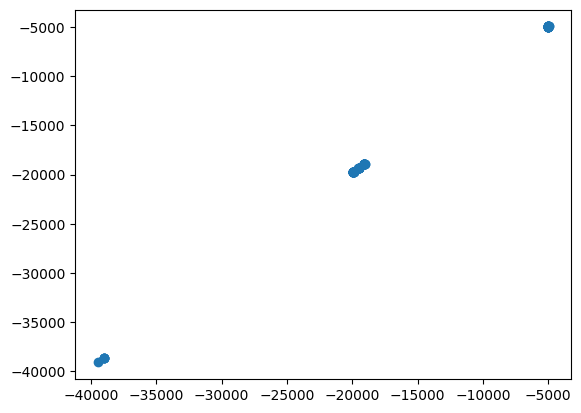

In [6]:
plt.scatter(energies[:, 0], energies[:, 1])

In [ ]:
cohesive_energy(s, {"Ti": -1604.604515075, "O": -432.503149303})

# Benchmarks

In [ ]:
import torch
from pathlib import Path
from aenet.torch_training import TorchANNPotential, TorchTrainingConfig, Structure, save_model
from aenet.torch_training.config import Adam  # <- optimizer + batch size here
from aenet.torch_featurize import ChebyshevDescriptor
from aenet.formats.xsf import XSFParser

# 1) Load a few structures (reuse your notebook’s loader or this quick one)
def load_tio2_structures(n_structs: int = 10):
    xsf_dir = Path("./xsf-TiO2")
    files = sorted(xsf_dir.glob("*.xsf"))[:n_structs]
    parser = XSFParser()
    out = []
    for p in files:
        s = parser.read(str(p))
        positions = s.coords[-1]
        species = list(s.types)
        energy = float(s.energy[-1])
        cell = None if not getattr(s, "pbc", False) else torch.tensor(s.avec[-1]).numpy()
        pbc = None if not getattr(s, "pbc", False) else torch.tensor([True, True, True]).numpy()
        out.append(Structure(positions=positions, species=species, energy=energy, forces=None, cell=cell, pbc=pbc, name=p.name))
    return out

structures = load_tio2_structures(100)

# 2) Descriptor and simple per-species architecture
descriptor = ChebyshevDescriptor(
    species=sorted({el for s in structures for el in s.species}),
    rad_order=10, rad_cutoff=6.0,
    ang_order=3, ang_cutoff=3.5,
    min_cutoff=0.5,
    device="cpu", dtype=torch.float64,
)

arch = {el: [(16, "tanh"), (16, "tanh")] for el in descriptor.species}
pot = TorchANNPotential(arch=arch, descriptor=descriptor)

# 3) Optimizer + batch size here (Adam.mu is the learning rate)
method = Adam(mu=1e-3, batchsize=16)  # <- control batch size

atomic_energies = {"Ti": -1604.604515075, "O": -432.503149303}

# Energy-only training (alpha=0.0):
cfg = TorchTrainingConfig(
    iterations=500,
    method=method,
    testpercent=10,
    force_weight=0.0,            # alpha=0.0 => energy-only
    memory_mode="cpu",
    device="cpu",
    normalize_features=True,
    normalize_energy=True,
    energy_target="total",       # or "cohesive" if you want to subtract atomic refs
    E_atomic=atomic_energies,    # set dict if energy_target="cohesive"
    show_progress=True,
)

history = pot.train(
    structures=structures,
    config=cfg,
    checkpoint_dir=None,         # or a path for checkpoints
    checkpoint_interval=0,
    max_checkpoints=0,
    save_best=False,
    use_scheduler=False,
)

# Optional: Switch to force training (more expensive but often improves accuracy):
# cfg.force_weight = 0.5         # alpha in [0,1]
# cfg.force_fraction = 0.25      # sample forces on a subset each epoch to speed up
# history = pot.train(structures, config=cfg)

# Save model
save_model(pot, Path("example-05-outputs") / "trained_model.pt")

for k in history:
    print(f"{k} = {history[k][-1]}")

In [ ]:
for k in history:
    print(f"{k} = {history[k][-1]}")

In [ ]:
# Save model
save_model(pot, Path("example-05-outputs") / "trained_model.pt")

In [1]:
epochs = range(1, len(history["train_energy_rmse"]) + 1)
plt.figure(figsize=(6,4))
plt.yscale('log')
plt.plot(epochs, history["train_energy_rmse"], label="train_energy_rmse")
if not math.isnan(history["test_energy_rmse"][0]):
    plt.plot(epochs, history["test_energy_rmse"], label="test_energy_rmse")
plt.xlabel("epoch"); plt.ylabel("RMSE (energy per-atom)"); plt.legend(); plt.tight_layout()
plot_path = outputs / "energy_rmse.png"
plt.savefig(plot_path, dpi=150)
plot_path

NameError: name 'history' is not defined